In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Load Datasets

In [3]:
calls = pd.read_csv('/Users/pendovka/Desktop/Data/Central Intake Service Queue Data.csv')
calls['Date'] = pd.to_datetime(calls['Date'])
calls.set_index('Date', inplace=True)  

In [4]:
occupancy = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2023.csv')

occupancy['OCCUPANCY_DATE'] = pd.to_datetime(occupancy['OCCUPANCY_DATE'])
occupancy.set_index('_id', inplace=True, drop=True)

occupancy.set_index('OCCUPANCY_DATE', inplace=True)
monthly_average_occupancy_rate = occupancy['OCCUPANCY_RATE_BEDS'].resample('MS').mean()

In [5]:
shelter_flow = pd.read_csv('/Users/pendovka/Desktop/Data/toronto-shelter-system-flow.csv')
shelter_flow.rename(columns={'date(mmm-yy)': 'Date'}, inplace=True)
shelter_flow['Date'] = pd.to_datetime(shelter_flow['Date'], format='%b-%y')
shelter_flow = shelter_flow.set_index('Date')

In [6]:
calls_full = pd.read_csv('/Users/pendovka/Desktop/Data/Central Intake Call Wrap-Up Codes Data.csv')
calls_full['Date'] = pd.to_datetime(calls_full['Date'])
calls_full.set_index('Date', inplace=True)
calls_full.rename(columns={'Code 3B - Shelter Space Unavailable - Individuals/Couples': 'shelter_unavailable_ind'}, inplace=True)

# Initial Correlation Analysis

In [7]:
average_daily_calls_unavailable = calls_full['shelter_unavailable_ind'].resample('MS').mean()
average_daily_total_calls = calls_full['Total calls handled'].resample('MS').mean()

monthly_calls = pd.merge(average_daily_calls_unavailable, average_daily_total_calls, on='Date', how='inner')
monthly_calls['unavailable_ratio'] = monthly_calls['shelter_unavailable_ind'] / monthly_calls['Total calls handled']

shelter_flow = shelter_flow[shelter_flow['population_group'] == 'All Population']

average_daily_unmatched = calls['Unmatched callers'].resample('MS').mean()
average_daily_unmatched.head()
monthly_calls_merge = pd.merge(monthly_calls, average_daily_unmatched , on= 'Date', how='inner')

In [8]:
merged_calls_flow_monthly = pd.merge(monthly_calls_merge, shelter_flow, left_index=True, right_index=True, how='inner')

merged_calls_flow_monthly = merged_calls_flow_monthly[merged_calls_flow_monthly.index.year < 2024]

merged_calls_flow_monthly.reset_index(inplace=True)

merged_calls_flow_monthly = merged_calls_flow_monthly[['Date', 'Total calls handled', 'Unmatched callers', 'newly_identified', 'actively_homeless', 'became_inactive']]

correlation_calls_newlyhomeless = merged_calls_flow_monthly[['Unmatched callers', 'newly_identified']].corr().iloc[0, 1]
correlation_calls_activelyhomeless = merged_calls_flow_monthly[['Unmatched callers', 'actively_homeless']].corr().iloc[0, 1]
correlation_calls_inactive = merged_calls_flow_monthly[['Unmatched callers', 'became_inactive']].corr().iloc[0, 1]

print(f"Correlation between the number of unmatched callers and newly homeless: {correlation_calls_newlyhomeless:.2f}")
print(f"Correlation between the number of unmatched callers and actively homeless: {correlation_calls_activelyhomeless:.2f}")
print(f"Correlation between the number of unmatched callers and inactive homeless: {correlation_calls_inactive:.2f}")

Correlation between the number of unmatched callers and newly homeless: 0.35
Correlation between the number of unmatched callers and actively homeless: 0.65
Correlation between the number of unmatched callers and inactive homeless: -0.35


# Merge all occupancy tables

95624 40943


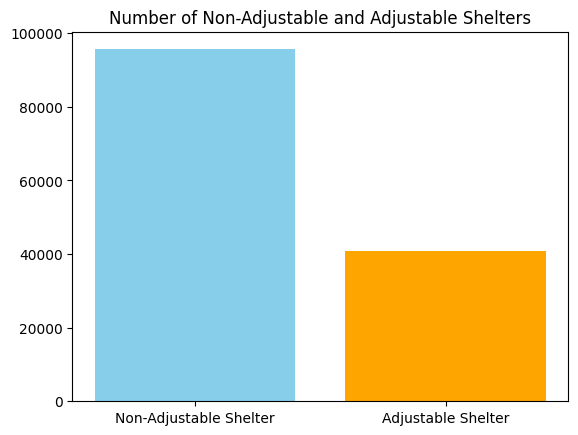

In [9]:
occupancy2024 = pd.read_csv('/Users/pendovka/Desktop/Data/Daily shelter overnight occupancy.csv')
occupancy2023 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2023.csv')
occupancy2022 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2022.csv')
occupancy2021 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2021.csv')

occupancy2021['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2021['OCCUPANCY_DATE'], format='%y-%m-%d').dt.strftime('%Y-%m-%d')
occupancy2022['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2022['OCCUPANCY_DATE'], format='%y-%m-%d').dt.strftime('%Y-%m-%d')
occupancy2023['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2023['OCCUPANCY_DATE'])
occupancy2024['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2024['OCCUPANCY_DATE'])
occupancy2024.head()

concatenated_occupancy = pd.concat([occupancy2024, occupancy2023, occupancy2022, occupancy2021])
concatenated_occupancy['OCCUPANCY_DATE'] = pd.to_datetime(concatenated_occupancy['OCCUPANCY_DATE'])
concatenated_occupancy.sort_values(by='OCCUPANCY_DATE', inplace=True)
concatenated_occupancy.set_index('OCCUPANCY_DATE', inplace=True)

count_non_adjustable_shelter = len(concatenated_occupancy[concatenated_occupancy['OVERNIGHT_SERVICE_TYPE'] == 'Shelter'])
count_adjustable_shelter = len(concatenated_occupancy[concatenated_occupancy['OVERNIGHT_SERVICE_TYPE'] == 'Motel/Hotel Shelter'])

print(count_non_adjustable_shelter, count_adjustable_shelter)

bar_positions = [0, 1]

bar_heights = [count_non_adjustable_shelter, count_adjustable_shelter]

bar_colors = ['skyblue', 'orange']

plt.bar(bar_positions, bar_heights, color=bar_colors)

plt.xticks(bar_positions, ['Non-Adjustable Shelter', 'Adjustable Shelter'])

plt.title('Number of Non-Adjustable and Adjustable Shelters')
plt.show()

We need to focus on Motel/Hotel type of shelters since they have adjustable capacity. Let's calculate averate daily capacity for for these.

In [10]:
concatenated_occupancy_flexible = concatenated_occupancy[concatenated_occupancy['OVERNIGHT_SERVICE_TYPE'] == 'Motel/Hotel Shelter'].copy()

concatenated_occupancy_flexible['CAPACITY_ACTUAL_ROOM'] = concatenated_occupancy_flexible['CAPACITY_ACTUAL_ROOM'].fillna(0).astype(int)
concatenated_occupancy_flexible['CAPACITY_ACTUAL_BED'] = concatenated_occupancy_flexible['CAPACITY_ACTUAL_BED'].fillna(0).astype(int)

concatenated_occupancy_flexible['capacity'] = concatenated_occupancy_flexible['CAPACITY_ACTUAL_ROOM'] + concatenated_occupancy_flexible['CAPACITY_ACTUAL_BED']

x = concatenated_occupancy_flexible.groupby('OCCUPANCY_DATE')['capacity'].sum()

average_daily_capacity = x.resample('MS').mean().rename('average_daily_capacity').round(2)
average_daily_capacity = average_daily_capacity.to_frame()


# Monthly merged dataset for Adjustable Capacity Shelters

In [31]:
merged_calls_occupancy_flow_monthly = pd.merge(average_daily_capacity, merged_calls_flow_monthly, left_index=True, right_on='Date', how='inner')

date_column = merged_calls_occupancy_flow_monthly['Date']
merged_calls_occupancy_flow_monthly.drop(columns=['Date'], inplace=True)
merged_calls_occupancy_flow_monthly.insert(0, 'Date', date_column)
merged_calls_occupancy_flow_monthly.set_index('Date', inplace=True)


merged_calls_occupancy_flow_monthly.tail(10)

,average_daily_capacity,Total calls handled,Unmatched callers,newly_identified,actively_homeless,became_inactive
Date,,,,,,
2023-03-01,2817.58,796.548387,119.838710,801,10811,683
2023-04-01,2758.03,827.033333,143.700000,766,10515,787
2023-05-01,2716.94,1024.032258,219.870968,1132,10453,773
2023-06-01,2701.43,1043.000000,273.533333,899,10418,701
2023-07-01,2625.39,859.419355,239.064516,599,10110,807
2023-08-01,2483.87,888.322581,244.258065,539,9988,632
2023-09-01,2471.83,979.866667,277.966667,841,10212,483
2023-10-01,2496.16,1094.161290,291.290323,929,10111,502
2023-11-01,2481.33,969.900000,245.300000,1113,10498,472


In [32]:
other_occupancy = concatenated_occupancy[concatenated_occupancy['OVERNIGHT_SERVICE_TYPE'] == 'Shelter'].copy()

other_occupancy['CAPACITY_ACTUAL_ROOM'] = other_occupancy['CAPACITY_ACTUAL_ROOM'].fillna(0).astype(int)
other_occupancy['CAPACITY_ACTUAL_BED'] = other_occupancy['CAPACITY_ACTUAL_BED'].fillna(0).astype(int)

other_occupancy['capacity'] = other_occupancy['CAPACITY_ACTUAL_ROOM'] + other_occupancy['CAPACITY_ACTUAL_BED']

y = other_occupancy.groupby('OCCUPANCY_DATE')['capacity'].sum()

average_other_daily_capacity = y.resample('MS').mean().rename('average_other_daily_capacity').round(2)
average_other_daily_capacity = average_other_daily_capacity.to_frame()


# Monthly merged dataset for Non-Adjustable Capacity Shelters

In [33]:
other_occupancy = concatenated_occupancy[concatenated_occupancy['OVERNIGHT_SERVICE_TYPE'] == 'Shelter'].copy()

other_occupancy['CAPACITY_ACTUAL_ROOM'] = other_occupancy['CAPACITY_ACTUAL_ROOM'].fillna(0).astype(int)
other_occupancy['CAPACITY_ACTUAL_BED'] = other_occupancy['CAPACITY_ACTUAL_BED'].fillna(0).astype(int)

other_occupancy['capacity'] = other_occupancy['CAPACITY_ACTUAL_ROOM'] + other_occupancy['CAPACITY_ACTUAL_BED']

y = other_occupancy.groupby('OCCUPANCY_DATE')['capacity'].sum()

average_other_daily_capacity = y.resample('MS').mean().rename('average_other_daily_capacity').round(2)
average_other_daily_capacity = average_other_daily_capacity.to_frame()

In [34]:
merged_calls_other_flow_monthly = pd.merge(average_other_daily_capacity, merged_calls_flow_monthly, left_index=True, right_on='Date', how='inner')


date_column = merged_calls_other_flow_monthly['Date']
merged_calls_other_flow_monthly.drop(columns=['Date'], inplace=True)
merged_calls_other_flow_monthly.insert(0, 'Date', date_column)
merged_calls_other_flow_monthly.set_index('Date', inplace=True)

merged_calls_other_flow_monthly.tail()

,average_other_daily_capacity,Total calls handled,Unmatched callers,newly_identified,actively_homeless,became_inactive
Date,,,,,,
2023-08-01,3829.71,888.322581,244.258065,539,9988,632
2023-09-01,3979.63,979.866667,277.966667,841,10212,483
2023-10-01,4077.35,1094.161290,291.290323,929,10111,502
2023-11-01,4132.60,969.900000,245.300000,1113,10498,472
2023-12-01,4196.26,805.935484,164.741935,886,10607,447


# Historical Analysis of Core Metrics

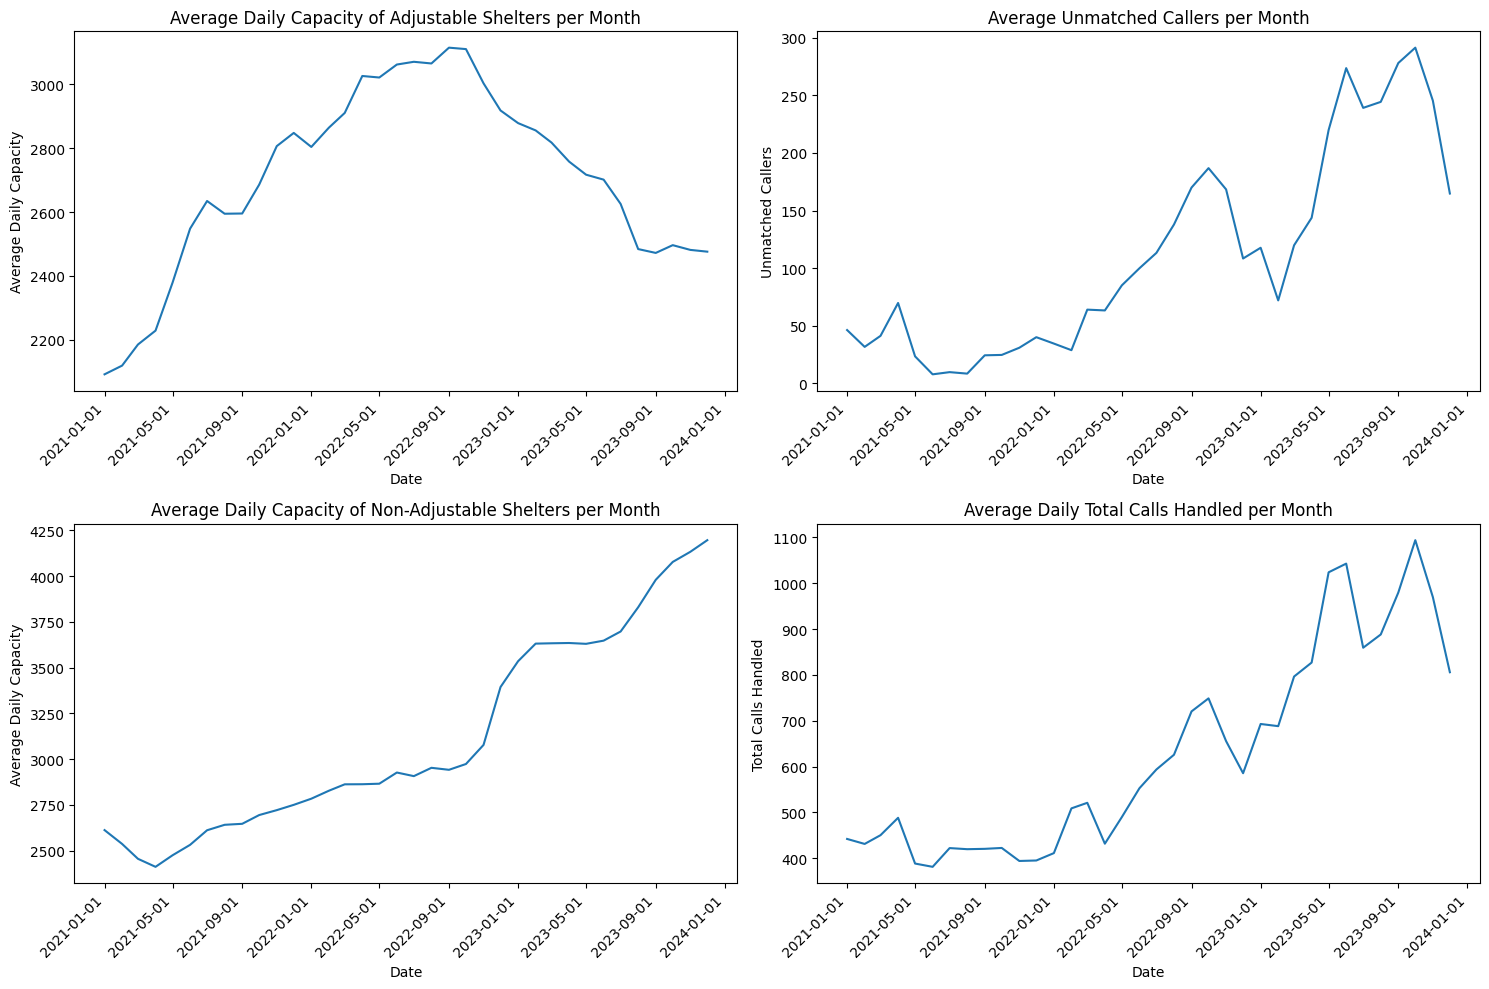

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

plt.subplot(2, 2, 1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot1 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_capacity')
    plot1.set_xticks(plot1.get_xticks())  # Set the x-axis tick positions
    plot1.set_xticklabels(plot1.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Average Daily Capacity')
plt.title('Average Daily Capacity of Adjustable Shelters per Month')

plt.subplot(2, 2, 2)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot2 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='Unmatched callers')
    plot2.set_xticks(plot2.get_xticks())  # Set the x-axis tick positions
    plot2.set_xticklabels(plot2.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Unmatched Callers')
plt.title('Average Unmatched Callers per Month')

plt.subplot(2, 2, 3)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot3 = sns.lineplot(data=merged_calls_other_flow_monthly, x='Date', y='average_other_daily_capacity')
    plot3.set_xticks(plot3.get_xticks())  # Set the x-axis tick positions
    plot3.set_xticklabels(plot3.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Average Daily Capacity')
plt.title('Average Daily Capacity of Non-Adjustable Shelters per Month')

plt.subplot(2, 2, 4)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot4 = sns.lineplot(data=merged_calls_other_flow_monthly, x='Date', y='Total calls handled')
    plot4.set_xticks(plot4.get_xticks())  # Set the x-axis tick positions
    plot4.set_xticklabels(plot4.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Total Calls Handled')
plt.title('Average Daily Total Calls Handled per Month')

plt.tight_layout()
plt.show()

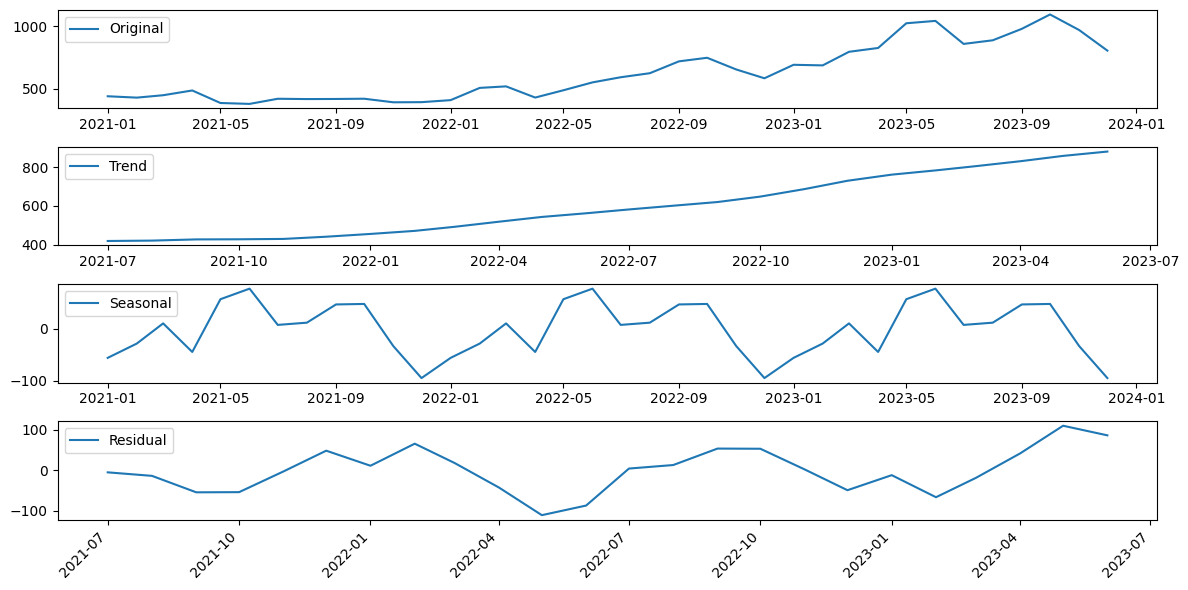

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(merged_calls_other_flow_monthly['Total calls handled'])

plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(merged_calls_other_flow_monthly.index, merged_calls_other_flow_monthly['Total calls handled'], label='Original')
plt.legend()

plt.subplot(412)
plt.plot(result.trend.index, result.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(result.seasonal.index, result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(result.resid.index, result.resid, label='Residual')
plt.legend()

plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()

In [37]:
tss = np.sum((merged_calls_other_flow_monthly['Total calls handled'] - np.mean(merged_calls_other_flow_monthly['Total calls handled']))**2)
rss = np.sum(result.resid**2)
sss = np.sum(result.seasonal**2)
proportion_explained = sss / tss

print(f"Proportion of variance explained by seasonality: {proportion_explained:.2%}")

Proportion of variance explained by seasonality: 5.30%


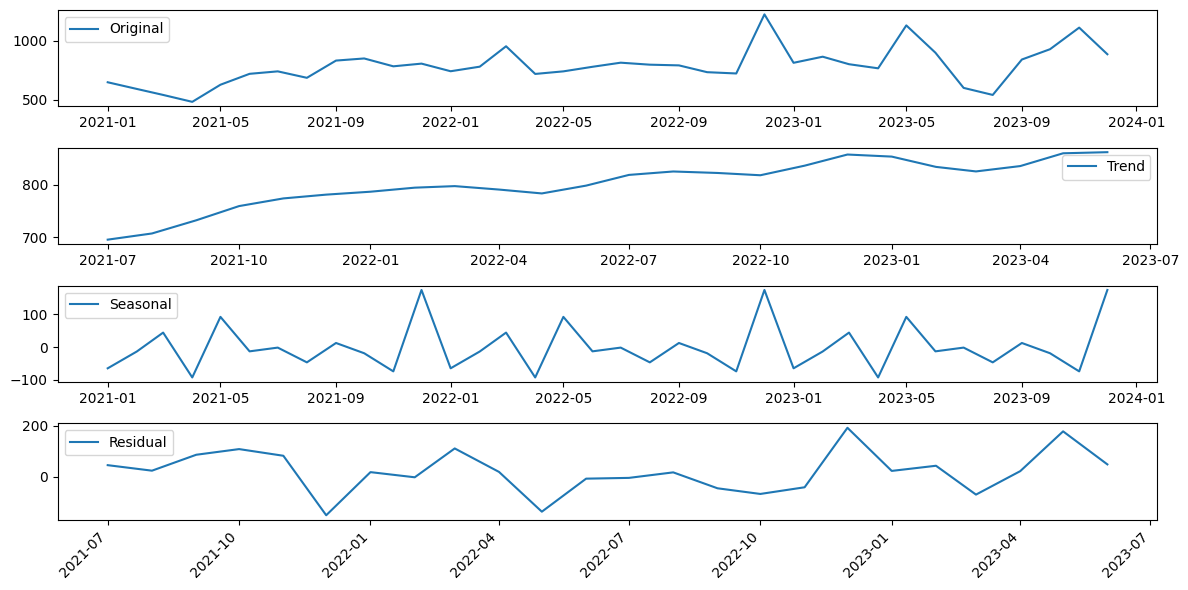

Proportion of variance in newly_identified explained by seasonality: 21.41%


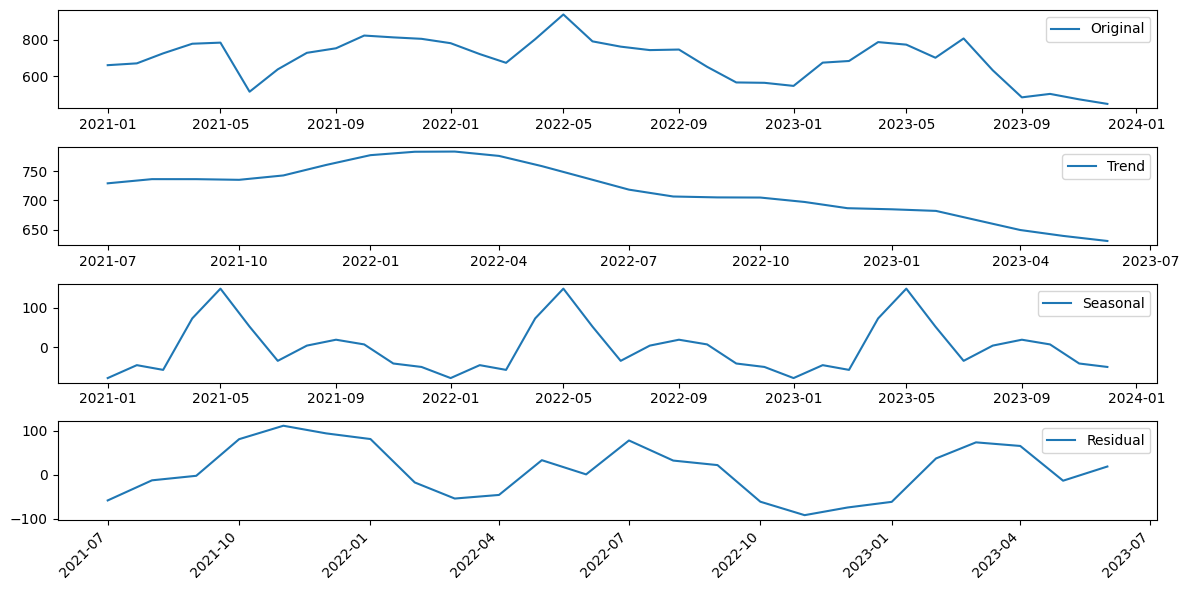

Proportion of variance in became_inactive explained by seasonality: 28.97%


In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

for variable in merged_calls_other_flow_monthly[['newly_identified', 'became_inactive']]:
    result = seasonal_decompose(merged_calls_other_flow_monthly[variable])

    plt.figure(figsize=(12, 6))
    plt.subplot(411)
    plt.plot(merged_calls_other_flow_monthly.index, merged_calls_other_flow_monthly[variable], label='Original')
    plt.legend()

    plt.subplot(412)
    plt.plot(result.trend.index, result.trend, label='Trend')
    plt.legend()

    plt.subplot(413)
    plt.plot(result.seasonal.index, result.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(414)
    plt.plot(result.resid.index, result.resid, label='Residual')
    plt.legend()

    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()

    tss = np.sum((merged_calls_other_flow_monthly[variable] - np.mean(merged_calls_other_flow_monthly[variable]))**2)
    rss = np.sum(result.resid**2)
    sss = np.sum(result.seasonal**2)
    proportion_explained = sss / tss

    print("Proportion of variance in {} explained by seasonality: {:.2%}".format(variable, proportion_explained))

newly_identified – people who entered the shelter system for the first time <br>
became_inactive – people who were using the shelter system previously, but have not used the shelter system in the past three months.